In [1]:
import csv
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
def FlatMtxRead(fmtxFN,firstMtx=-1,mtxNum=-1,verb=0):
    lnCnt=0
    mtxTimeDict={}    
    fmtxIn=open(fmtxFN,"r")
    for line in fmtxIn:
        if firstMtx!=-1 and lnCnt<firstMtx:
            lnCnt+=1
            continue
        data=list(map(str,line.split(":")))
        timeBeg=int(data[0].split("-")[0])
        timeEnd=int(data[0].split("-")[1])
        fmtx=list(map(float,data[1].split(",")))
        mtx = np.reshape(fmtx, (8, 8))
        np.shape(mtx)
        mtxTimeDict[(timeBeg,timeEnd)]=mtx
    fmtxIn.close()
    return mtxTimeDict

def WeightDistrRead(wdFN,firstMtx=-1,mtxNum=-1,verb=0):
    lnCnt=0
    wdTimeDict={}    
    fWDIn=open(wdFN,"r")
    for line in fWDIn:
        if firstMtx!=-1 and lnCnt<firstMtx:
            lnCnt+=1
            continue
        data=list(map(str,line.split(":")))
        timeBeg=int(data[0].split("-")[0])
        timeEnd=int(data[0].split("-")[1])
        wd=list(map(float,data[1].split(",")))
        wdTimeDict[(timeBeg,timeEnd)]=wd        
    fWDIn.close()        
    return wdTimeDict

def WeightNorm(mtxTimeDict,wdTimeDict,verb=0):
    wmtxTimeDict={}
    for tper in mtxTimeDict:    
        mtxWN=np.copy(mtxTimeDict[tper])
        wd=np.copy(wdTimeDict[tper])
        for i in range(len(mtxWN)):
            for j in range(len(wd)):
                if wd[j]>0.:
                    mtxWN[i][j]=mtxWN[i][j]/wd[j]
        wmtxTimeDict[tper]=mtxWN
    return wmtxTimeDict

def Epoch2datetime(epoch):
    dt = datetime.datetime.fromtimestamp(epoch).strftime('%Y-%m-%dT%H:%M:%SZ')
    return dt

def PlotCtMtx(mtx,fnOut=-1,ftitle="Reference weekday - AgeNorm",blabel="No. of contacts/head",cm="Blues",cmin=-1,cmax=-1,lognorm=-1):
    
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(8,8))
    cmp=""
    if cm=="Oranges":cmp=plt.cm.Oranges
    elif cm=="Blacks":cmp=plt.cm.gray_r
    elif cm=="Blues":cmp=plt.cm.Blues
    elif cm=="Reds":cmp=plt.cm.Reds
    elif cm=="Greens":cmp=plt.cm.Greens
    else:cm=plt.cm.rainbow
    
    if cmin==1:
        cmin=np.amin(mtx[mtx!=0.])
    elif cmin==-1:
        cmin=np.amin(mtx)
    
    if cmax==-1:
        cmax=mtx.max()
    
    if lognorm==-1:
        plt.matshow(mtx, cmap=cmp,origin="lower",fignum=1)
    else:
        plt.matshow(mtx, cmap=cmp,norm=LogNorm(),origin="lower",fignum=1)
    plt.title(ftitle)
    plt.clim(cmin,cmax)
    plt.colorbar(fraction=0.046, pad=0.04,label=blabel)
    plt.gca().xaxis.tick_bottom()
    plt.xticks([0,1,2,3,4,5,6,7],["0-4","5-14","15-29","30-44","45-59","60-69","70-79","80+"],rotation=45)
    plt.yticks([0,1,2,3,4,5,6,7],["0-4","5-14","15-29","30-44","45-59","60-69","70-79","80+"])
    plt.xlabel("ego age")
    plt.ylabel("contact age")
    if fnOut!=-1:
        plt.savefig(fnOut,bbox_inches='tight')        

# Time period selection

In [3]:
wds=7  # window size
wsh=1  # window shift
periodIdx=11  # period index to plot (0...number of periods generated-1)

In [5]:
fActMtxFN="./results/ActKAFMtxDyn_t_fmtx8x8_wds"+str(wds)+"_wsh"+str(wsh)+".csv"
print(fActMtxFN)
mtxTimeDict=FlatMtxRead(fmtxFN=fActMtxFN,firstMtx=-1,mtxNum=-1,verb=0)
tIdxDict={}
perCnt=0
for tper in mtxTimeDict:
    tIdxDict[perCnt]=tper
    print("Index: ",perCnt," time period: ",Epoch2datetime(tper[0])[:10],"--",Epoch2datetime(tper[1])[:10], " in epoch: ",tper[0],"--",tper[1])
    perCnt+=1

./results/ActKAFMtxDyn_t_fmtx8x8_wds7_wsh1.csv
Index:  0  time period:  2020-03-24 -- 2020-03-31  in epoch:  1585087200 -- 1585691999
Index:  1  time period:  2020-03-25 -- 2020-04-01  in epoch:  1585173600 -- 1585778399
Index:  2  time period:  2020-03-26 -- 2020-04-02  in epoch:  1585260000 -- 1585864799
Index:  3  time period:  2020-03-27 -- 2020-04-03  in epoch:  1585346400 -- 1585951199
Index:  4  time period:  2020-03-28 -- 2020-04-04  in epoch:  1585432800 -- 1586037599
Index:  5  time period:  2020-03-30 -- 2020-04-05  in epoch:  1585519200 -- 1586123999
Index:  6  time period:  2020-03-31 -- 2020-04-06  in epoch:  1585605600 -- 1586210399
Index:  7  time period:  2020-04-01 -- 2020-04-07  in epoch:  1585692000 -- 1586296799
Index:  8  time period:  2020-04-02 -- 2020-04-08  in epoch:  1585778400 -- 1586383199
Index:  9  time period:  2020-04-03 -- 2020-04-09  in epoch:  1585864800 -- 1586469599
Index:  10  time period:  2020-04-04 -- 2020-04-10  in epoch:  1585951200 -- 158655

# Adult actual proxy matrix - read and plot

In [6]:
fActKAFMtxFN="./results/ActKAFMtxDyn_t_fmtx8x8_wds"+str(wds)+"_wsh"+str(wsh)+".csv"
mtxKAFTimeDict=FlatMtxRead(fmtxFN=fActKAFMtxFN,firstMtx=-1,mtxNum=-1,verb=0)

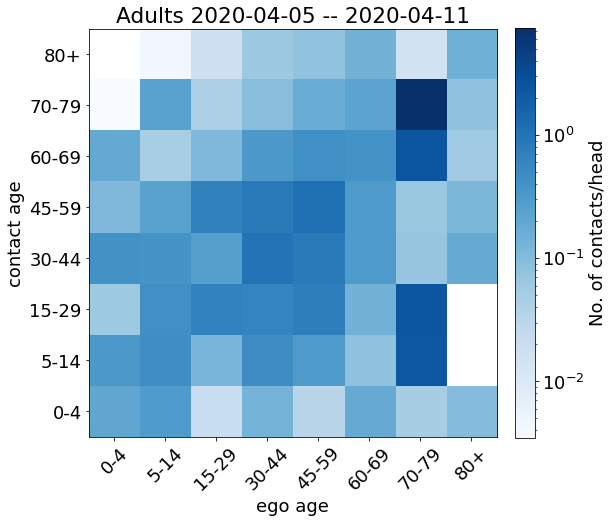

In [7]:
blabel="No. of contacts/head"
cmap="Blues"

tper=tIdxDict[periodIdx]

mtx=mtxKAFTimeDict[tper]
ftitle="Adults "+str(Epoch2datetime(tper[0])[:10])+" -- "+str(Epoch2datetime(tper[1])[:10])
if mtx.min()==0:
    PlotCtMtx(mtx,fnOut=-1,ftitle=ftitle,blabel=blabel,cm=cmap,cmin=1,lognorm=1)
else:
    PlotCtMtx(mtx,fnOut=-1,ftitle=ftitle,blabel=blabel,cm=cmap,cmin=-1,lognorm=1)